# VGG16 Transfer Learning on CBIS DDSM

This notebook exploits Transfer Learning on the VGG16 CNN architecture (pre-trained on ImageNet) for abnormality classification (mass-calcification) on mammography images taken from the CBIS DDSM dataset.

# Environment setup

In [0]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# Copy the dataset from Google Drive to local

!cp "/content/gdrive/My Drive/CBIS_DDSM.zip" .
!unzip -qq CBIS_DDSM.zip
!rm CBIS_DDSM.zip
cbis_path = 'CBIS_DDSM'

In [0]:
# Import libraries

%tensorflow_version 1.x
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

# Data pre-processing

In [0]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to 0->mass 1->calcification
    """
    if l == 1 or l == 2:
        return 0
    elif l == 3 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

The data is prepared following these steps:


1.   Import the training and testing data from numpy arrays
2.   Remove the images and labels related to baseline patches (even indices in the arrays)
3.   Adjust the labels for the binary classification problem, so that 0 corresponds to 'mass' and 1 maps to 'calcification'
4.   Normalize the pixels to be in the range (0-1) floating point
5.   Replicate the color channel three times, since VGG expects BGR images as input.
6.   Shuffle the training set (and labels accordingly, of course)
7.   Split the training data into 'training' and 'validation' subsets
8.   Build Keras generators for training and validation data

In [0]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 256
test_images = test_images.astype('uint16') / 256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

Train size: 2676 	 Test size: 336
Image size: 150x150


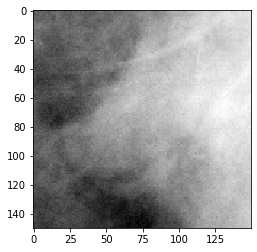

Label: 0


In [0]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

# VGG16

## Model definition

In [0]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(150, 150, 3))

    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(1, activation='sigmoid'))

    # Freeze the convolutional base
    vgg16_base.trainable = False

    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128

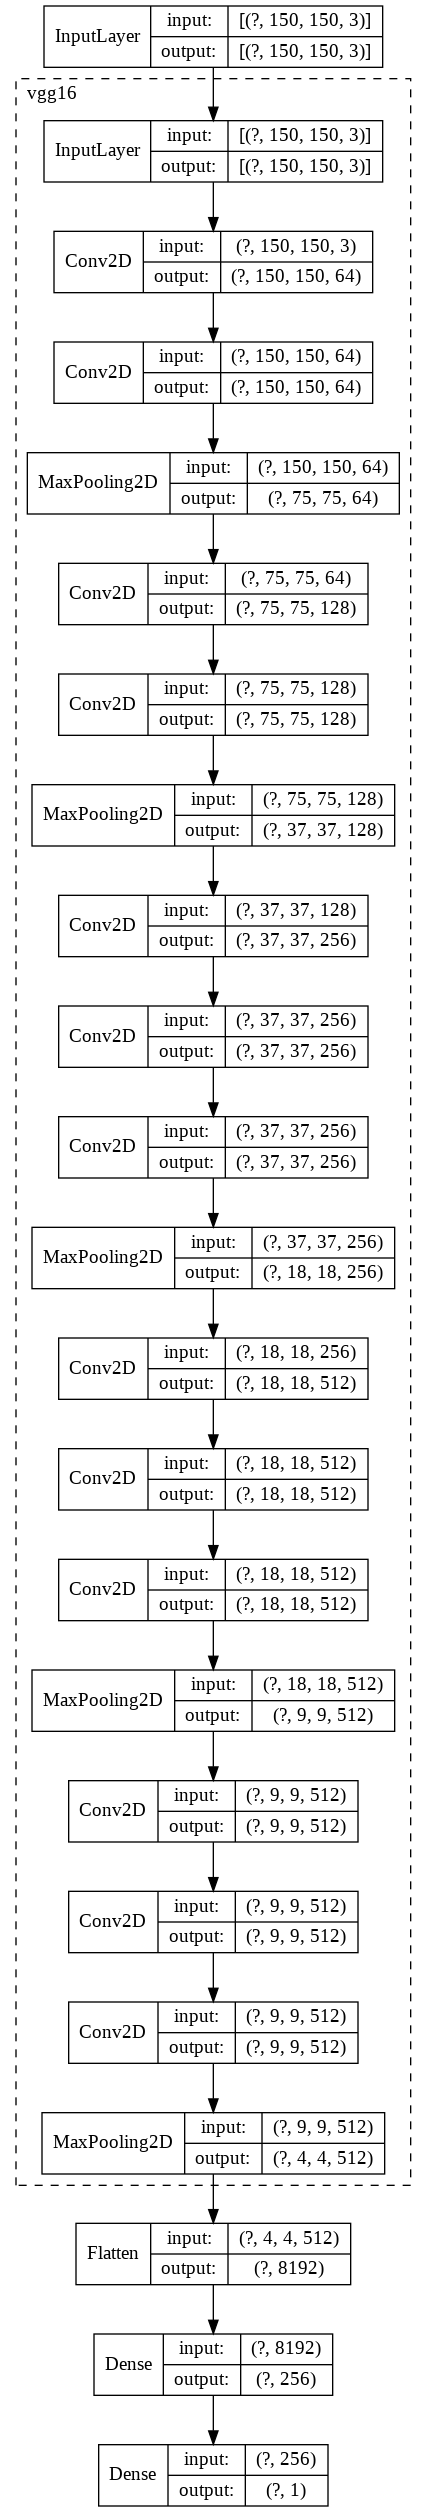

In [0]:
# Show the VGG16 architecture

vgg16_example = create_vgg16(verbose=True)
plot_model(vgg16_example, to_file='vgg16.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True)

## Feature extraction

### Vanilla

The original VGG16 comes with a couple of 4096 FC layers followed by 1000 softmax neurons, which is alright for ImageNet but definitely oversized for our purpose. Hence, the convolutional base is left as it is, and the fully-connect block is shrinked to a single layer with 256 neurons feeding one sigmoidal output unit.

In [0]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe = create_vgg16()

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_vgg16_fe = vgg16_fe.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(vgg16_fe, 'vgg16_fe_2cl_end.h5')
!cp vgg16_fe* "/content/gdrive/My Drive/models/"

Epoch 1/200
 5/20 [======>.......................] - ETA: 15s - loss: 0.3880 - acc: 0.8505
Epoch 00001: val_loss improved from inf to 0.38802, saving model to vgg16_fe_2cl_best.h5
20/20 [==============================] - 21s 1s/step - loss: 1.3304 - acc: 0.7453 - val_loss: 0.3880 - val_acc: 0.8505
Epoch 2/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.3888 - acc: 0.8636
Epoch 00002: val_loss did not improve from 0.38802
20/20 [==============================] - 16s 796ms/step - loss: 0.4200 - acc: 0.8214 - val_loss: 0.3888 - val_acc: 0.8636
Epoch 3/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.3526 - acc: 0.8617
Epoch 00003: val_loss improved from 0.38802 to 0.35255, saving model to vgg16_fe_2cl_best.h5
20/20 [==============================] - 17s 848ms/step - loss: 0.4184 - acc: 0.8233 - val_loss: 0.3526 - val_acc: 0.8617
Epoch 4/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.3630 - acc: 0.8430
Epoch 00004: val_loss did not improve fr

In [0]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe.history['loss']
tra_acc_fe = history_vgg16_fe.history['acc']
val_loss_fe = history_vgg16_fe.history['val_loss']
val_acc_fe = history_vgg16_fe.history['val_acc']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe = models.load_model('vgg16_fe_2cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Feature Extraction

Epoch [end]: 43
Epoch [opt]: 13
Valid accuracy [end]: 0.8748
Valid accuracy [opt]: 0.8654
Test accuracy [end]:  0.8631
Test accuracy [opt]:  0.8690
Valid loss [end]: 0.3849
Valid loss [opt]: 0.2886
Test loss [end]:  0.5318
Test loss [opt]:  0.4320


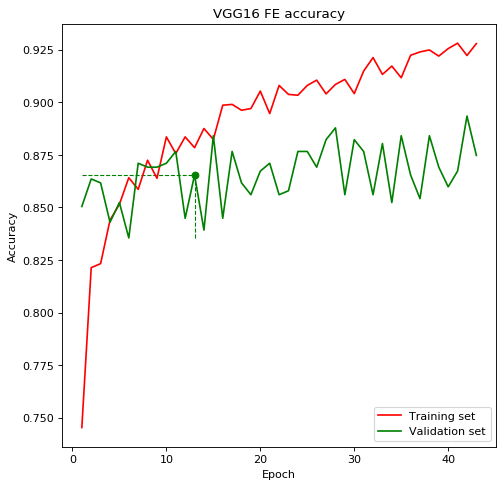

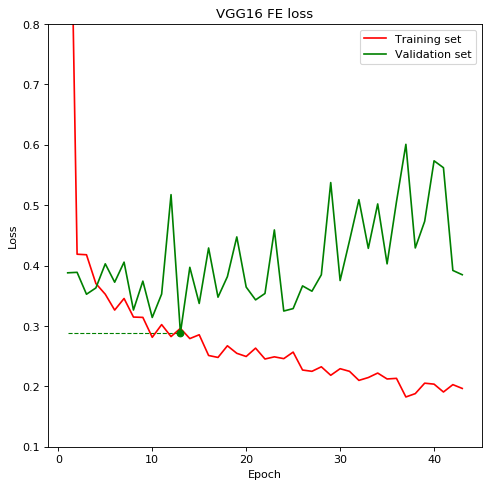

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.1,0.8)
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: The network learns very fast to distinguish between masses and calcifications, with a more than 86% accuracy. On the other hand, by looking at the loss graph, it begins overfitting very soon: some regularization method is very needed.

### With dropout

Dropout is added at the end of the network to mitigate overfitting.

In [0]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop = create_vgg16(dropout=0.5)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_vgg16_fe_drop = vgg16_fe_drop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(vgg16_fe_drop, 'vgg16_fe_drop_2cl_end.h5')
!cp vgg16_fe* "/content/gdrive/My Drive/models/"

Epoch 1/200
 5/20 [======>.......................] - ETA: 15s - loss: 0.4951 - acc: 0.7626
Epoch 00001: val_loss improved from inf to 0.49512, saving model to vgg16_fe_drop_2cl_best.h5
20/20 [==============================] - 21s 1s/step - loss: 1.4196 - acc: 0.7394 - val_loss: 0.4951 - val_acc: 0.7626
Epoch 2/200
 5/20 [======>.......................] - ETA: 15s - loss: 0.3853 - acc: 0.8318
Epoch 00002: val_loss improved from 0.49512 to 0.38525, saving model to vgg16_fe_drop_2cl_best.h5
20/20 [==============================] - 16s 814ms/step - loss: 0.4906 - acc: 0.7944 - val_loss: 0.3853 - val_acc: 0.8318
Epoch 3/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.3763 - acc: 0.8280
Epoch 00003: val_loss improved from 0.38525 to 0.37630, saving model to vgg16_fe_drop_2cl_best.h5
20/20 [==============================] - 17s 827ms/step - loss: 0.4690 - acc: 0.8020 - val_loss: 0.3763 - val_acc: 0.8280
Epoch 4/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.37

In [0]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop.history['loss']
tra_acc_fe = history_vgg16_fe_drop.history['acc']
val_loss_fe = history_vgg16_fe_drop.history['val_loss']
val_acc_fe = history_vgg16_fe_drop.history['val_acc']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop = models.load_model('vgg16_fe_drop_2cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout) Feature Extraction

Epoch [end]: 65
Epoch [opt]: 35
Valid accuracy [end]: 0.8804
Valid accuracy [opt]: 0.8710
Test accuracy [end]:  0.8482
Test accuracy [opt]:  0.8750
Valid loss [end]: 0.3649
Valid loss [opt]: 0.2940
Test loss [end]:  0.5110
Test loss [opt]:  0.4637


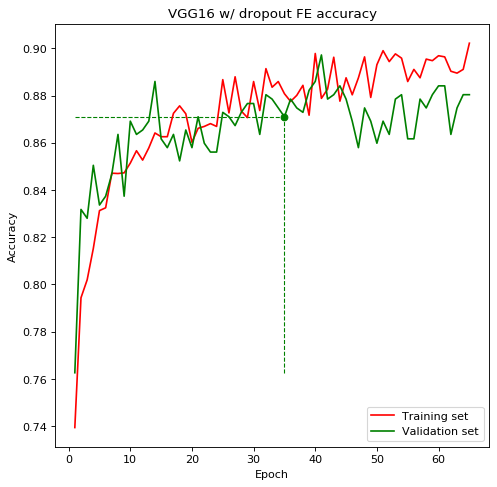

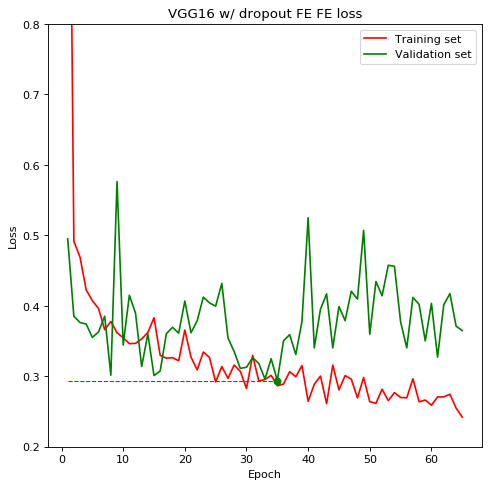

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.2, 0.8)
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: dropout mitigated the magnitude of overfitting, but was not enough to eliminate it.
Overall, the training time increased and the testing accuracy improved to 87.5%.

### With dropout and smaller FC

In [0]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_2cl_end.h5')
!cp vgg16_fe* "/content/gdrive/My Drive/models/"

Epoch 1/200
 5/20 [======>.......................] - ETA: 15s - loss: 0.4872 - acc: 0.7981
Epoch 00001: val_loss improved from inf to 0.48723, saving model to vgg16_fe_drop_128_2cl_best.h5
20/20 [==============================] - 22s 1s/step - loss: 1.1171 - acc: 0.7277 - val_loss: 0.4872 - val_acc: 0.7981
Epoch 2/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.3848 - acc: 0.8299
Epoch 00002: val_loss improved from 0.48723 to 0.38481, saving model to vgg16_fe_drop_128_2cl_best.h5
20/20 [==============================] - 15s 765ms/step - loss: 0.4609 - acc: 0.8035 - val_loss: 0.3848 - val_acc: 0.8299
Epoch 3/200
 5/20 [======>.......................] - ETA: 13s - loss: 0.4266 - acc: 0.8093
Epoch 00003: val_loss did not improve from 0.38481
20/20 [==============================] - 16s 803ms/step - loss: 0.4275 - acc: 0.8092 - val_loss: 0.4266 - val_acc: 0.8093
Epoch 4/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.3758 - acc: 0.8561
Epoch 00004: val_loss 

In [0]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['acc']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_acc']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_2cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 85
Epoch [opt]: 65
Valid accuracy [end]: 0.8841
Valid accuracy [opt]: 0.8748
Test accuracy [end]:  0.8631
Test accuracy [opt]:  0.8661
Valid loss [end]: 0.3330
Valid loss [opt]: 0.2930
Test loss [end]:  0.4137
Test loss [opt]:  0.4261


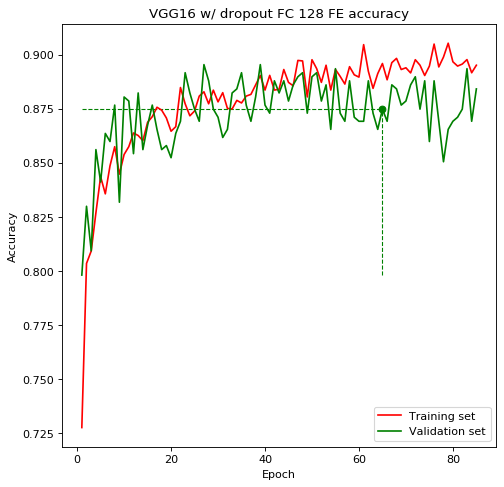

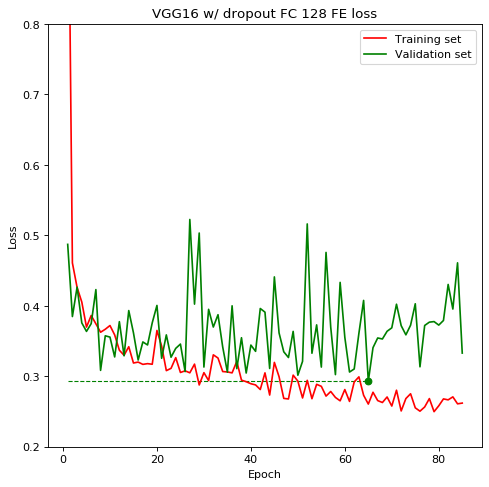

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.2, 0.8)
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: By shrinking the last fully-connected layer and with the use of dropout, overfitting went down even more. However, the FC resize slightly hurted the performance, in terms of training time and final accuracy.

### Harder data augmentation

The training set is already augmented, yet its intensity can be increased with more radical transformations. The next experiment extends the shearing range to 15° (from 10°) and introduces shifts up to 20\% of the size. The aim is to have a more variegated training set so to reduce overfitting.

In [0]:
# New generator with more aggressive data augmentation parameters
train_datagen_hardaugm = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

train_datagen_hardaugm.fit(train_images)

train_generator_hardaugm = train_datagen_hardaugm.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator_hardaugm = train_datagen_hardaugm.flow(train_images, train_labels, batch_size=128, subset='validation')

In [0]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_hardaugm = create_vgg16(dropout=0.5)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_hardaugm_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_hardaugm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_vgg16_fe_hardaugm = vgg16_fe_hardaugm.fit_generator(
        train_generator_hardaugm,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator_hardaugm,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(vgg16_fe_hardaugm, 'vgg16_fe_hardaugm_2cl_end.h5')
!cp vgg16_fe* "/content/gdrive/My Drive/models/"

Epoch 1/200
 5/20 [======>.......................] - ETA: 15s - loss: 0.4675 - acc: 0.7776
Epoch 00001: val_loss improved from inf to 0.46748, saving model to vgg16_fe_hardaugm_2cl_best.h5
20/20 [==============================] - 23s 1s/step - loss: 1.1645 - acc: 0.7156 - val_loss: 0.4675 - val_acc: 0.7776
Epoch 2/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.4724 - acc: 0.7551
Epoch 00002: val_loss did not improve from 0.46748
20/20 [==============================] - 15s 742ms/step - loss: 0.5298 - acc: 0.7731 - val_loss: 0.4724 - val_acc: 0.7551
Epoch 3/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.4930 - acc: 0.7738
Epoch 00003: val_loss did not improve from 0.46748
20/20 [==============================] - 17s 845ms/step - loss: 0.5265 - acc: 0.7791 - val_loss: 0.4930 - val_acc: 0.7738
Epoch 4/200
 5/20 [======>.......................] - ETA: 15s - loss: 0.4061 - acc: 0.7963
Epoch 00004: val_loss improved from 0.46748 to 0.40610, saving model to v

In [0]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_hardaugm.history['loss']
tra_acc_fe = history_vgg16_fe_hardaugm.history['acc']
val_loss_fe = history_vgg16_fe_hardaugm.history['val_loss']
val_acc_fe = history_vgg16_fe_hardaugm.history['val_acc']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_hardaugm = models.load_model('vgg16_fe_hardaugm_2cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_hardaugm.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_hardaugm.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout, hard augmentation) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, hard augmentation) Feature Extraction

Epoch [end]: 103
Epoch [opt]: 73
Valid accuracy [end]: 0.8654
Valid accuracy [opt]: 0.8748
Test accuracy [end]:  0.8571
Test accuracy [opt]:  0.8571
Valid loss [end]: 0.3518
Valid loss [opt]: 0.2910
Test loss [end]:  0.4265
Test loss [opt]:  0.3940


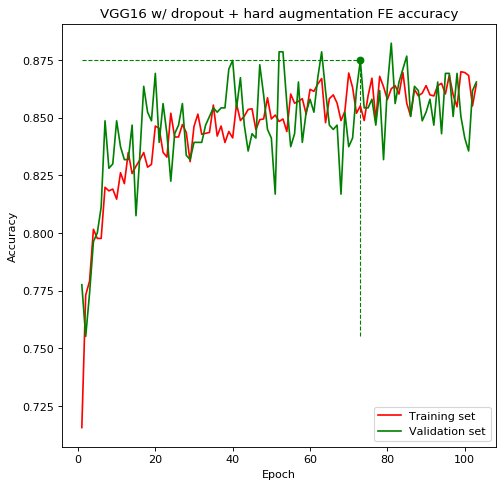

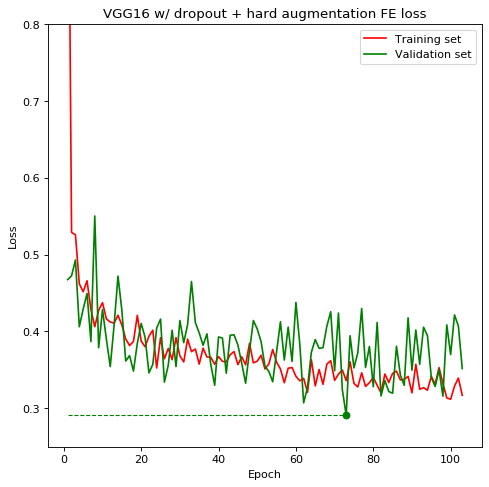

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout + hard augmentation FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout + hard augmentation FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.25, 0.8)
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: The use of a stronger data augmentation drastically reduced the overfit. The test accuracy remained more or less unchanged, which indicates that the network performance has been already pushed to the limit.

## Fine tuning

### 1 layer

In [0]:
!cp "/content/gdrive/My Drive/models/vgg16_fe_hardaugm_2cl_best.h5" .
vgg16_ft_1layer = models.load_model('vgg16_fe_hardaugm_2cl_best.h5')

# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 4,457,473
Non-trainable params: 12,354,880
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)       

In [0]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_2cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

# Train
history_ft = vgg16_ft_1layer.fit_generator(
        train_generator_hardaugm,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator_hardaugm,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

# Save
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_2cl_end.h5')
!cp vgg16_ft* "/content/gdrive/My Drive/models/"

Epoch 1/200
 5/20 [======>.......................] - ETA: 15s - loss: 0.3672 - acc: 0.8654
Epoch 00001: val_loss improved from inf to 0.36725, saving model to vgg16_ft_2cl_best.h5
20/20 [==============================] - 22s 1s/step - loss: 0.3734 - acc: 0.8442 - val_loss: 0.3672 - val_acc: 0.8654
Epoch 2/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.4365 - acc: 0.8486
Epoch 00002: val_loss did not improve from 0.36725
20/20 [==============================] - 14s 721ms/step - loss: 0.3432 - acc: 0.8578 - val_loss: 0.4365 - val_acc: 0.8486
Epoch 3/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.3295 - acc: 0.8598
Epoch 00003: val_loss improved from 0.36725 to 0.32946, saving model to vgg16_ft_2cl_best.h5
20/20 [==============================] - 16s 813ms/step - loss: 0.3340 - acc: 0.8660 - val_loss: 0.3295 - val_acc: 0.8598
Epoch 4/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.3105 - acc: 0.8673
Epoch 00004: val_loss improved from 0.32

In [0]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['acc']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_acc']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_2cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 86
Epoch [opt]: 56
Valid accuracy [end]: 0.8748
Valid accuracy [opt]: 0.8972
Test accuracy [end]:  0.8988
Test accuracy [opt]:  0.8958
Valid loss [end]: 0.3527
Valid loss [opt]: 0.2484
Test loss [end]:  0.3711
Test loss [opt]:  0.3228


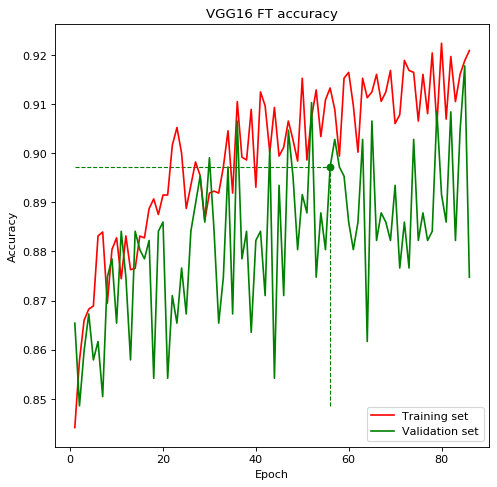

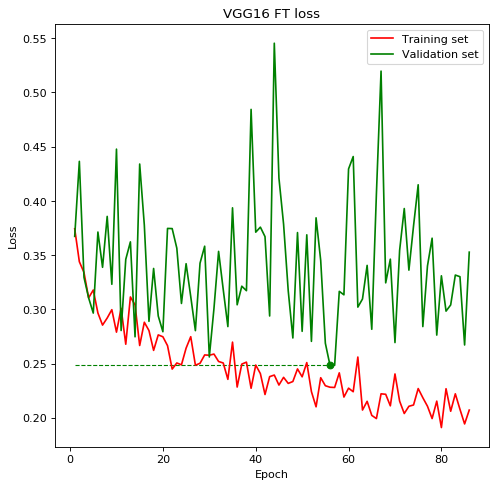

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: Thanks to fine tuning, the NN scored 89.58\% accuracy on the testing set, with a gain of 1% compared to the previous feature extraction VGG16 models.

### 2 layers

The same process can be applied iteratively, this time starting from the 1-layer fine-tuned model and unfreezing the penultimate convolutional layer.

In [0]:
!cp "/content/gdrive/My Drive/models/vgg16_ft_1layer_2cl_best.h5" .
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_2cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256

In [0]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_2cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

# Train
history_ft_2layer = vgg16_ft_2layer.fit_generator(
        train_generator_hardaugm,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator_hardaugm,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

# Save
models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_2cl_end.h5')
!cp vgg16_ft* "/content/gdrive/My Drive/models/"

Epoch 1/200
 5/20 [======>.......................] - ETA: 15s - loss: 0.3279 - acc: 0.8991
Epoch 00001: val_loss improved from inf to 0.32794, saving model to vgg16_ft_2layer_2cl_best.h5
20/20 [==============================] - 23s 1s/step - loss: 0.4550 - acc: 0.8313 - val_loss: 0.3279 - val_acc: 0.8991
Epoch 2/200
 5/20 [======>.......................] - ETA: 13s - loss: 0.2807 - acc: 0.9159
Epoch 00002: val_loss improved from 0.32794 to 0.28069, saving model to vgg16_ft_2layer_2cl_best.h5
20/20 [==============================] - 16s 813ms/step - loss: 0.3095 - acc: 0.8777 - val_loss: 0.2807 - val_acc: 0.9159
Epoch 3/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.2882 - acc: 0.8991
Epoch 00003: val_loss did not improve from 0.28069
20/20 [==============================] - 16s 798ms/step - loss: 0.3227 - acc: 0.8679 - val_loss: 0.2882 - val_acc: 0.8991
Epoch 4/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.2260 - acc: 0.9234
Epoch 00004: val_loss impr

In [0]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['acc']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_acc']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_2cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (2 layers)

Epoch [end]: 39
Epoch [opt]: 9
Valid accuracy [end]: 0.8991
Valid accuracy [opt]: 0.9103
Test accuracy [end]:  0.8988
Test accuracy [opt]:  0.9137
Valid loss [end]: 0.3963
Valid loss [opt]: 0.1935
Test loss [end]:  0.4995
Test loss [opt]:  0.3312


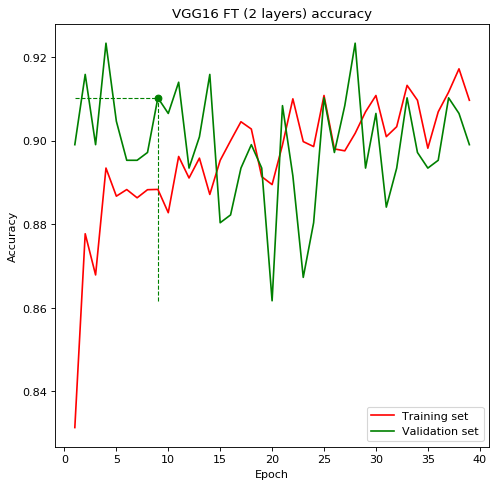

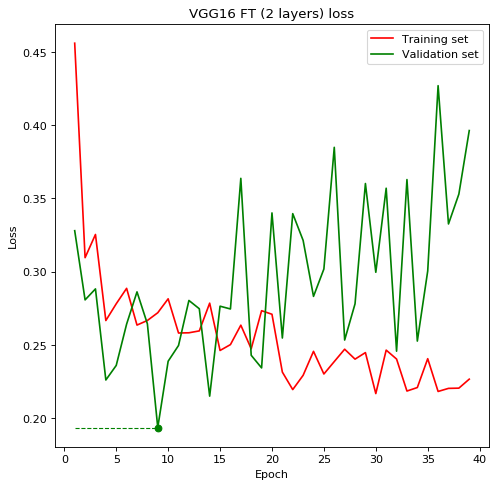

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: after very few epochs, the validation loss dropped very low and the accuracy reached the outstanding value of 91.4\% on the testing set.
The network started immediately after; indeed, unfreezing the second layer left too many network parameters free for tuning, so the result we got is basically the best we can get from it.
 For this reason, fine-tuning a 3rd layer would not be helpful at all.